In [11]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

%pylab inline

%pylab.rcParams['figure.figsize'] = (10, 6)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


1. [Fundamentals](#Fundamentals)
2. [Solving Equations](#Solving-Equations)
3. [Systems of Equations](#Systems-of-Equations)
4. [Interpolation](#Interpolation)
5. [Least Squares](#Least-Squares)
6. [Numerical Differentiation and Integration](#Numerical-Differentiation-and-Integration)
7. [Ordinary Differential Equations](#Ordinary-Differential-Equations)

# Fundamentals

## Binary

Represented by ones and zeros.

$$
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\cdots & 1 & 0 & 1 & 0 & 0 & 1 & 1 & 0\\
\hline
\cdots & 128 & 64 & 32 & 16 & 8 & 4 & 2 & 1\\
\hline
\end{array}
$$

Just sum up each place that has a one digit. (For example, the above number is 166)

##Floating Point

The value of a number is computed as

$$
\text{sign} \cdot 2^\text{exponent} \cdot \text{mantissa}
$$

"The sign is stored in bit 32. The exponent can be computed from bits 24-31 by subtracting 127. The mantissa (also known as significand or fraction) is stored in bits 1-23. An invisible leading bit (i.e. it is not actually stored) with value 1.0 is placed in front, then bit 23 has a value of 1/2, bit 22 has value 1/4 etc. As a result, the mantissa has a value between 1.0 and 2. If the exponent reaches -127 (binary 00000000), the leading 1 is no longer used to enable gradual underflow." -http://www.h-schmidt.net/FloatConverter/IEEE754.html

# Solving Equations

##Bisection Method

In [12]:
def bisectionmethod(f, a, b, steps, precision=1e-4):
    m = np.zeros((steps, 2))
    m[0, 0] = a
    m[0, 1] = bcd
    for i in range(1, steps):
        c = (m[i - 1, 0] + m[i - 1, 1]) / 2
        if f(c) == 0:
            return c, m
        elif np.abs(f(a) - f(b)) <= precision:
            return c, m
        elif f(a) * f(c) < 0:
            m[i, 0] = m[i - 1, 0]
            m[i, 1] = c
        else:
            m[i, 0] = c
            m[i, 1] = m[i - 1, 1]
    return (m[-1, 0] + m[-1, 1]) / 2, m

##Fixed Point Iteration

A number, $x^*$, is called a fixed point if $g(x^*) = x^*$. If we're lucky, some functions converge to a certain point.

In [13]:
def fixedpointmethod(f, x0, steps):
    m = np.zeros(steps)
    m[0] = x0
    for i in range(1, steps):
        m[i] = f(m[i - 1])
        if np.abs(m[i] - m[i - 1]) < 0.0001:
            break
    return m[-1], m

##Newton's Method

In [14]:
def newtonsmethod(f, x0, steps, precision=1e-4):
    m = np.zeros(steps)
    m[0] = x0
    for i in range(1, steps):
        m[i] = m[i - 1] - (f(m[i - 1]) / sm.derivative(f, m[i - 1]))
        if np.abs(f(m[i])) < precision:
            break
    return m[i], len(np.nonzero(m)[0])

##Secant Method

In [15]:
def secantmethod(f, x0, x1, steps):
    m = np.zeros((steps, 2))
    m[0, 0] = x0
    m[0, 1] = x1
    for i in range(1, steps):
        c = (m[i - 1, 1] - f(m[i - 1, 1]) *
             ((m[i - 1, 1] - m[i - 1, 0]) /
              (f(m[i - 1, 1]) - f(m[i - 1, 0]))))
        m[i, 0] = m[i - 1, 1]
        m[i, 1] = c
        
        if np.abs(m[i, 1] - m[i, 0]) < 0.001:
            break
    return c, m

# Systems of Equations

##Properties and Definitions

A system of equations can be defined by a matrix, usually denoted $Ax = b$.

A singular matrix is one where no solution exists. For $A$ which a unique solution exists the following statements are equivalent.

* $A$ is non-singular
* $A^{-1}$ exists
* $|A| \neq 0$
* $rank (A) = n$
* $\forall \vec{v} \neq 0, A \vec{v} \neq 0$.

Eigenvalues of some matrix $A$ are defined as the roots of the characteristic polynomial:

$$
| A - I \lambda | = 0
$$

A matrix is said to be ill-conditioned if the value $\lVert A \rVert \lVert A^{-1} \rVert$ is large.

##Gaussian Elimination

We have three elementary operations that we can use to solve systems of equations in matrix form with Naive Gaussian Elimination.

* Swap one equation for another.
* Add or subtract a multiple of one equation from another
* Multiply an equation by a nonzero constant

##LU Factorization

Any system of equations with coefficient matrix $A$ and solution vector $b$ can be written in the form $Ax = b$. $LU$ Factorization strives to reduce this coefficient matrix into two matrices, a lower and upper triangular matrix (hence the $LU$).

####No Pivoting
We use our elementary operations here, and each constant we use is "saved" in an identity matrix which becomes our lower triangular matrix at the end.

####Partial Pivoting

In this method we compare numbers before carrying out an elimination step. In the case of the first pivot, the largest entry of the first column is located and swapped for the first row. For the next pivot, the highest second column row is used for the second pivot.

We can use this to get the decomposition $PA=LU$, where $P$ is some permutation matrix that defines the row swapping that occurs.

We use the same system here, save that we can keep the multipliers in the reduced matrix and then split at the end.

# Interpolation

Let's establish a sample dataset to show the differences in these interpolation methods.

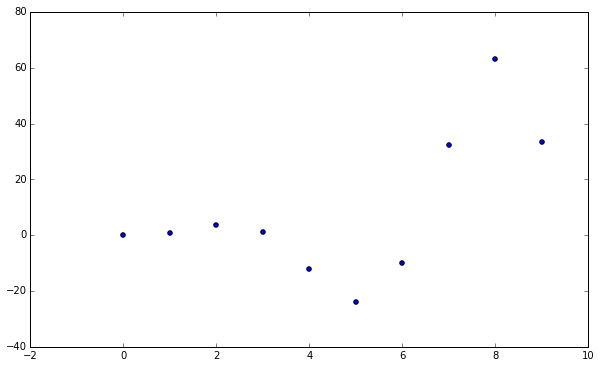

In [16]:
data = np.array([np.arange(0, 10), np.arange(0, 10)**2 * np.sin(np.arange(0, 10))])
plt.figure()
plt.scatter(data[0], data[1])
plt.show()

## Linear Interpolation

Between two points is simply defined as:

$$
y_0 + \frac{y_0 - y_1}{x_0 - x_1} (x - x_0)
$$

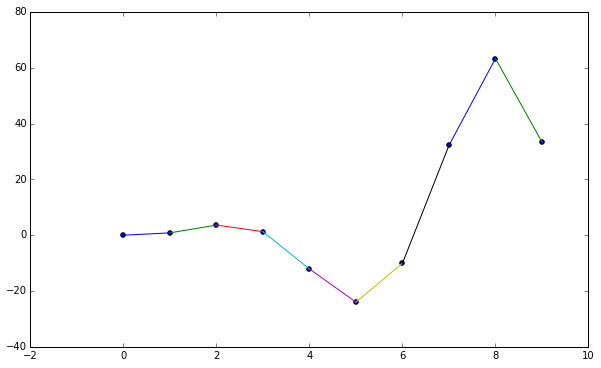

In [17]:
def linear_interpolation(point1, point2):
    """
    Interpolates a line between two given points.
    
    :param point[12]: tuple(float, float)
        Coordinates for points
    :returns: function
        Equation for interpolated line
    """
    return lambda x: (point1[1] +
            ((point1[1] - point2[1]) /
             (point1[0] - point2[0])) *
            (x - point1[0]))

def linearpoint(point1, point2, x):
    return linear_interpolation(point1, point2)(x)

plt.figure()
plt.scatter(data[0], data[1])
for i in range(len(data[0]) - 1):
    plt.plot(data[0, i:i + 2],
             linear_interpolation((data[0, i], data[1, i]),
                                  (data[0, i + 1], data[1, i + 1]))(data[0, i:i + 2]))
plt.show()

##Lagrangian Interpolation

Given a set of $k + 1$ points, $(x_0, y_0), \cdots, (x_k, y_k)$, with distinct $x_i$, the lagrangian polynomial is the linear combination

$$
L(x) = \sum_{j=0}^k y_j l_j(x)
$$

Where

$$
l_j(x) = \prod_{0\le m \le k, m \neq j} \frac{x - x_m}{x_j - x_m}
$$

See http://en.wikipedia.org/wiki/Lagrange_polynomial

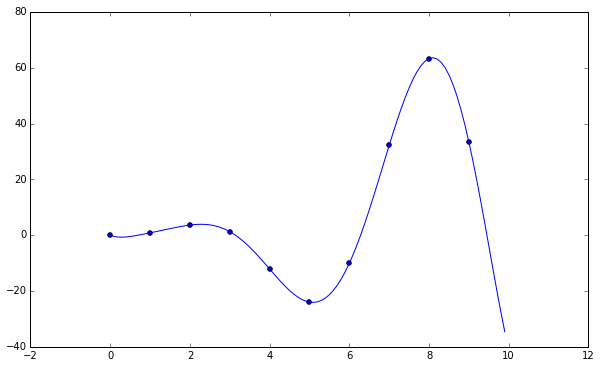

In [18]:
def lagrangian_polynomial(points, xarr):
    """
    Lagrangian Polynomial at a set of points
    """
    if type(xarr) in [int, float]:
        return lagrangian_point(points, xarr)
    else:
        return np.array([lagrangian_point(points, x) for x in xarr])

def lagrangian_point(points, x):
    """
    Finds the Langrangian interpolating polynomial
    in two dimensions at point x
    
    A set of k points.
    """
    Lx = []
    for j in range(len(points)):
        lx = []
        for m in range(len(points)):
            if m != j:
                lx.append(((x - points[m, 0]) /
                        (points[j, 0] - points[m, 0])))
        Lx.append(points[j, 1] * np.prod(lx))
    Lx = np.sum(Lx)
    return Lx

plt.figure()
plt.scatter(data[0], data[1])
plt.plot(np.arange(0, 10, 0.1),
         lagrangian_polynomial(np.transpose(data), np.arange(0, 10, 0.1)))
plt.show()

##Newton's Divided Differences

For the same set of points, the Newton Interpolating Polynomial is

$$
N(x) = \sum_{j = 0}^k a_j n_j(x)
$$

Where

$$
n_j(x) = \prod_{i = 0}^{j - 1} (x - x_i)
$$

and

$$
a_j = [y_0, \ldots, y_j]
$$

which is the notation for divided differences, defined as

$$
[y_v, \ldots, y_{v+j}] = \frac{[y_{v + 1}, \ldots, y_{v + j}] - [y_v, \ldots, y_{v + j - 1}]}{x_{v + j} - x_v}
$$

See http://en.wikipedia.org/wiki/Newton_polynomial

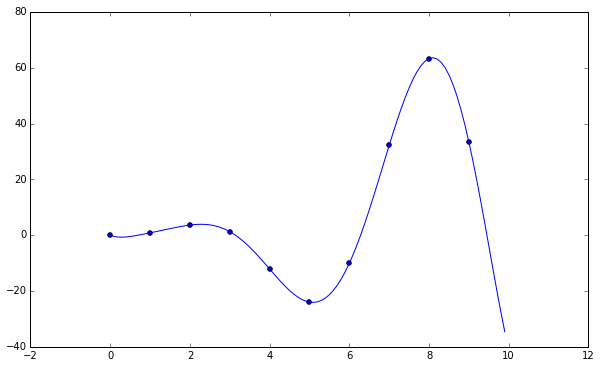

In [19]:
def divided_differences(data):
    """ http://mathworld.wolfram.com/DividedDifference.html """
    if len(data) == 1:
        return data[0, 1]
    else:
        return ((divided_differences(data[:-1]) -
                 divided_differences(data[1:])) /
                (data[0, 0] - data[-1, 0]))

def newtons_differences(points, xarr):
    """
    Lagrangian Polynomial at a set of points
    """
    if type(xarr) in [int, float]:
        return newtons_differences_point(points, xarr)
    else:
        return np.array([newtons_differences_point(points, x)
                         for x in xarr])

def newtons_differences_point(data, x):
    """
    Newton's divided differences for polynomials
    
    http://mathworld.wolfram.com/NewtonsDividedDifferenceInterpolationFormula.html
    """
    pin = lambda y, n: np.prod([(y - data[k, 0])
                             for k in range(n)])
    Nx = data[0, 1]
    for i in range(1, len(data)):
        Nx += pin(x, i) * divided_differences(data[:i + 1])
    return Nx

plt.figure()
plt.scatter(data[0], data[1])
plt.plot(np.arange(0, 10, 0.1),
         newtons_differences(np.transpose(data), np.arange(0, 10, 0.1)))
plt.show()

If you'll note, both Lagrangian interpolation and Newton's divided differences result in the same polynomial.

##Splines

In short, for the natural cubic spline, let us define $\delta_i = x_{i + 1} - x_i$ and $\Delta_i = y_{i + 1} - y_i$.

We now create the following system of equations.

$$
\left[
\begin{array}{cccccc|c}
1 & 0 & 0 & & & & 0\\
\delta_1 & 2 \delta_1 + 2\delta_2 & \delta_2 & \ddots & & & 3 \left( \frac{\Delta_2}{\delta_2} - \frac{\Delta_1}{\delta_1} \right)\\
0 & \delta_2 & 2 \delta_2 + 2 \delta_3 & \delta_3 & & & \\
& \ddots & \ddots & \ddots & \ddots & & \vdots \\
& & & \delta_{n - 2} & 2 \delta_{n - 2} + 2 \delta_{n - 1} & \delta_{n - 1} & 3 \left( \frac{\Delta_{n - 1}}{\delta_{n - 1}} - \frac{\Delta_{n - 2}}{\delta_{n - 2}} \right)\\
& & & 0 & 0 & 1 & 0\\
\end{array}
\right]
$$

The natural cubic spline is

$$
S_i(x) = a_i + b_i(x - x_i) + c_i (x - x_i)^2 + d_i (x - x_i)^3
$$

On $[x_i, x_{i + 1}]$, for $i = 1, \ldots, n - 1$ where

$$
\begin{aligned}
a_i &=& y_i\\
b_i &=& \frac{\Delta_i}{\delta_i} - \frac{\delta_i}{3} (2c_i + c_{i + 1})\\
c_i &=& \text{Solutions to above System}\\
d_i &=& \frac{c_{i + 1} - c_i}{3 \delta_i}
\end{aligned}
$$

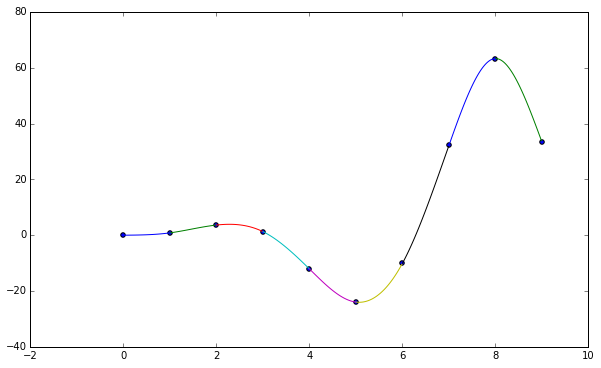

In [20]:
def cubic_natural_spline(data):
    """
    Fits a cubic spline to the points
    """
    a = np.zeros((len(data), len(data)), dtype=int)
    b = np.zeros((len(data), 1))
    a[0, 0] = 1
    a[-1, -1] = 1
    xdelta = lambda c: data[c + 1, 0] - data[c, 0]
    ydelta = lambda c: data[c + 1, 1] - data[c, 1]
    # System of equations
    for i in range(1, len(data) - 1):
        for j in range(len(data)):
            if i - 1 == j:
                a[i, j] = xdelta(i - 1)
            if i == j:
                a[i, j] = (2 * xdelta(i - 1) +
                           2 * xdelta(i))
            if i + 1 == j:
                a[i, j] = xdelta(i)
    for i in range(1, len(data) - 1):
        b[i, 0] = 3 * ((ydelta(i) / xdelta(i)) -
                       (ydelta(i - 1) / xdelta(i - 1)))
    # We've already written a matrix solver
    sols = np.linalg.solve(a, b)
    # Extract splines
    # Again, stupid python currying
    def gen_spline(a, b, c, d, x):
        return lambda y: (a +
                       b * (y - x) +
                       c * (y - x)**2 +
                       d * (y - x)**3)
    splines = []
    for i in range(len(data) - 1):
        d = (sols[i + 1] - sols[i]) / (3 * xdelta(i))
        b = (ydelta(i) / xdelta(i)) - ((xdelta(i) / 3) *
                                (2 * sols[i] + sols[i + 1]))
        splines.append(gen_spline(data[i, 1], b, sols[i], d, data[i, 0]))
    return splines

plt.figure()
plt.scatter(data[0], data[1])
lines = cubic_natural_spline(np.transpose(data))
for i in range(len(lines)):
    x = np.arange(data[0, i], data[0, i + 1], 0.01)
    plt.plot(x, lines[i](x))
plt.show()

##Bezier Curves

Cubic Bezier curves can be explicitly defined as

$$
B(t) = (1 - t)^3 P_0 + 3 (1 - t)^2 t P_1 + 3(1 - t) t^2 P_2 + t^3 P_3
$$

For $t \in [0, 1]$, for each set of four points, $P_0, \ldots, P_3$.

See http://en.wikipedia.org/wiki/B%C3%A9zier_curve

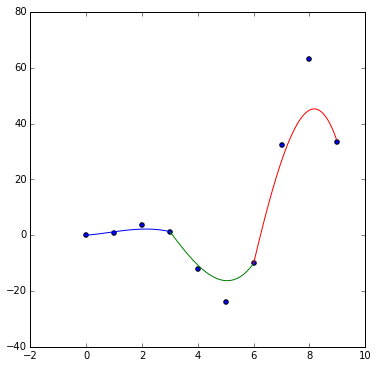

In [21]:
def bezier(points):
    """
    Draw's bezier polynomials.
    """
    if len(points) % 3 != 1:
        print('Please submit 1+3n points.')
        return
    
    # Have to curry because of python scoping
    def createcurve(p0, p1, p2, p3):
        return lambda tarr: np.array([((1 - t)**3 * p0 +
                           3 * (1 - t)**2 * t * p1 +
                           3 * (1 - t) * t**2 * p2 +
                           t**3 * p3) for t in tarr])
    
    curves = []
    for i in range(int(len(points) / 4) + 1):
        curves.append(createcurve(points[3 * i],
                                  points[3 * i + 1],
                                  points[3 * i + 2],
                                  points[3 * i + 3]))
        if len(points) == 4:
            break
    return curves

plt.figure(figsize=(6, 6))
curves = bezier(np.transpose(data))
plt.scatter(data[0], data[1])
for i in range(int(len(data[0]) / 4) + 1):
    plt.plot(curves[i](np.arange(0, 1, 0.01))[:, 0],
             curves[i](np.arange(0, 1, 0.01))[:, 1])
plt.show()

##3D Interpolation

With gridded data we can simply interpolate between the points. For non gridded data things get harder.

A great strategy is nearest neighbor interpolation:

$$
z = \begin{cases} \frac{\sum_{i = 1}^{N - 1} \frac{z_i}{{\left[ {(x_i - x)}^2 + {(y_i - y)}^2 \right]}^{p / 2}}}{\sum_{i = 1}^{N - 1} \frac{1}{{\left[ {(x_i - x)}^2 + {(y_i - y)}^2 \right]}^{p / 2}}} & \quad x_i \neq x \text{ or } y_i \neq y\\ z_i & \quad x_i = x \text{ and } y_i = y \end{cases}
$$

# Least Squares

If we have some unsolvable system of equations we call it inconsistent. We can find a solution that is "close" called the least squares solution.

We can find the normal equation.

$$
A^T A \bar{x} = A^T b
$$

Solving this minimizes the residual $r = b - AX$.

We can measure our error, where the root mean squared error is defined as

$$
RSME = \sqrt{\frac{SE}{m}} = \sqrt{\frac{r_1^2 + \cdots + r^2_m}{m}}
$$

We can apply this concept and fit models to data.

**Given a set of $m$ points:**

1. Choose a parameterized model.
2. Force the model to fit the data.
3. Solve the normal equations: $A^TAx = A^Tb$. The values, $c_i$, that correspond with the solution are the coefficients for the chosen model.

We can choose any model, just so long as it can be linearized. For example,

$$
\begin{aligned}
y = c_1 + c_2 t &\Rightarrow& \left[\begin{array}{cc}
1 & t_1\\
1 & t_2\\
\vdots & \vdots
\end{array}\right] \left[\begin{array}{c} c_1 \\ c_2 \end{array} \right] =
\left[ \begin{array}{c} y_1 \\ y_2 \\ \vdots\end{array} \right]\\
y = c_1 + c_2 t + c_3 t^2 &\Rightarrow& \left[\begin{array}{ccc}
1 & t_1 & t_1^2\\
1 & t_2 & t_2^2\\
\vdots & \vdots & \vdots
\end{array}\right] \left[\begin{array}{c} c_1 \\ c_2 \\ c_3 \end{array} \right] =
\left[ \begin{array}{c} y_1 \\ y_2 \\ \vdots\end{array} \right]\\\\
\end{aligned}
$$

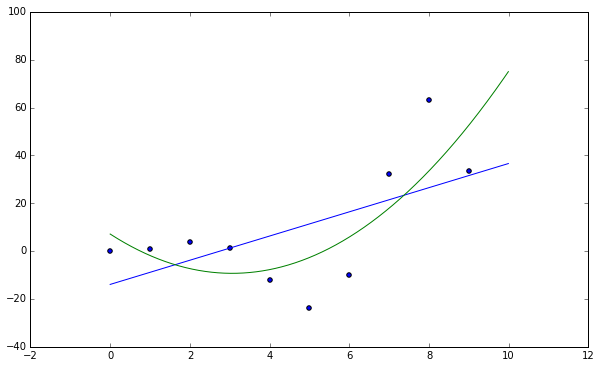

In [22]:
plt.figure()
plt.scatter(data[0], data[1])
coeff1 = np.polyfit(data[0], data[1], 1)
coeff2 = np.polyfit(data[0], data[1], 2)
line = lambda x: coeff1[0] * x    + coeff1[1]
para = lambda x: coeff2[0] * x**2 + coeff2[1] * x + coeff2[2]
plt.plot(np.arange(0, 10, 0.01), line(np.arange(0, 10, 0.01)))
plt.plot(np.arange(0, 10, 0.01), para(np.arange(0, 10, 0.01)))
plt.show()

##QR Factorization

We can do something better than the normal equations for least squares. The Gram-Schmidt process orthagonalizes a set of vectors by using the vector's length to get a unit vector.

### Reduced QR Factorization

Reduced QR factorization is defined as

$$
(A_1 \cdots A_n) = (q_1 \cdots q_n) \left[\begin{array}{cccc}
r_{11} & r_{12} & \cdots & r_{1n}\\
& r_{22} & \cdots & r_{2n}\\
& & \ddots & \vdots\\
& & & r_{nn}
\end{array}\right]
$$

Defining $y_j$ as

$$
y_j = A_j - q_1 (q_1^T A_j) - q_2(q_2^T A_j) - \cdots - q_{j - 1} ( q_{j - 1}^TA_j)
$$

Where $q_j$ is some vector defined as

$$
q_j = \frac{y_j}{{\lVert y_j \rVert}_2}
$$

and $r_{ij}$ is some constant defined as

$$
r_{jj} = {\lVert y_j \rVert}_2 \qquad r_{ij} = q_i^T A_j
$$

Note, a square matrix $Q$ is orthogonal if $Q^T = Q^{-1}$.

In [23]:
def reduced_qr(a):
    m, n = a.shape
    q = np.zeros((m, n))
    r = np.zeros((n, n))
    for j in range(n):
        y = a[:, j]
        for i in range(j - 1):
            r[i, j] = np.dot(np.transpose(q[:, i]), a[:, j])
            y = y - r[i, j] * q[:, i]
        r[j, j] = np.sqrt(np.sum(y**2))
        q[:, j] = y / r[j, j]
    return q, r
q, r = reduced_qr(np.array([[1, -4], [2, 3], [2, 2]]))
print(q)
print(r)
print(np.dot(q, r))

[[ 0.33333333 -0.74278135]
 [ 0.66666667  0.55708601]
 [ 0.66666667  0.37139068]]
[[ 3.          0.        ]
 [ 0.          5.38516481]]
[[ 1. -4.]
 [ 2.  3.]
 [ 2.  2.]]


###Full QR Factorization

Full factorization is defined as $A = QR$ where $Q$ is an orthogonal square matrix and $R$ is an upper triangular matrix the same size as $A$. Therefore, if $A$ is not square, a third arbitrary column that is linearly independent of the first two columns may be used.

###Least Squares by QR Factorization

Given some $m \times m$ inconsistent system $Ax = b$, find the full $QR$ factorization and set $\hat{R} = $ upper $n \times n$ submatrix of $R$ and $\hat{d} =$ upper $n$ entries of $d = Q^T b$.

Solve $\hat{R} \bar{x} = \hat{d}$ for the least squares solution $\bar{x}$.

###Gram-Schmidt Process

A unit vector is defined as 

$$
\frac{A}{\lVert A \rVert}
$$

The projection of vector $\vec{v}$ onto vector $\vec{u}$ is defined as

$$
proj_{\vec{u}} (\vec{v}) = \frac{\langle \vec{v}, \vec{u} \rangle}{\langle \vec{u}, \vec{u} \rangle}\vec{u}
$$

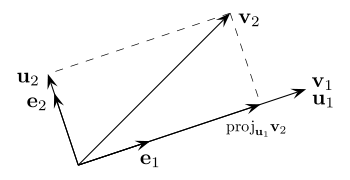

In [24]:
Image('350px-Gram–Schmidt_process.svg.png') # From wikipedia

##Householder Reflectors

A better way to find the $QR$ factorization is using householder reflectors.

**Householder Reflectors:** Let $x$ and $w$ be vectors with $\lVert x \rVert_2 = \lVert w \rVert_2$ and define $v = w - x$. Then $H = I - \frac{2vv^T}{v^Tv}$ is a symmetric orthogonal matrix and $Hx=w$.

We can use these to find the $QR$ decomposition.

1. Let $x_1$ be the first column of $A$.
2. Let $w_1 = \pm (\lVert x_1 \rVert_2, 0, \ldots, 0)$ (Choose sign opposite of the first component of $x$).
3. Create $H_1 = I - \frac{2 (w_1 - x_1)(w_1 - x_1)^T}{(w_1 - x_1)^T(w_1 - x_1)}$.
4. Create $x_2$ consisting of the $m - 1$ lower entries from column two of $H_1 A$ and $w_2$ in the same way save with the leading entry of $x_2$. Now define this to be $\hat{H}$, and set $H_2$ to be the $m \times m$ matrix formed by putting $\hat{H}_2$ in the lower part of the identity matrix.
5. Repeat step 4 as needed.

In [25]:
def householder_qr(a):
    def fit_to_identity(a):
        n = a.shape[1]
        i = np.eye(m)
        i[m - n:, m - n:] = a
        return i
    def householder_reflection(v):
        r = 2 * v.transpose().dot(v) / v.dot(v.transpose())
        v = np.eye(len(v[0])) - r
        return v
    def matrix_array_prod(arr):
        prod = np.eye(len(arr[0][0]))
        for i in range(len(arr)):
            prod = prod.dot(arr[i])
        return prod
    m, n = a.shape
    h_arr = []
    count = 0
    prod = a
    for i in range(n):
        w = np.zeros(m - count)
        w[0] = np.sqrt(np.sum(prod[count:, i]**2))
        v = np.array([w - prod[count:, i]])
        h = fit_to_identity(householder_reflection(v))
        h_arr.append(h)
        prod = matrix_array_prod(h_arr + [a])
        count += 1
    r = matrix_array_prod(h_arr[::-1] + [a])
    q = matrix_array_prod(h_arr)
    return q, r

q, r = householder_qr(np.array([[1, -4],
                                [2, 3],
                                [2, 2]]))
print(q)
print(r)
print(np.dot(q, r))

[[ 0.33333333 -0.93333333 -0.13333333]
 [ 0.66666667  0.33333333 -0.66666667]
 [ 0.66666667  0.13333333  0.73333333]]
[[  3.00000000e+00   2.00000000e+00]
 [ -2.22044605e-16   5.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]]
[[ 1. -4.]
 [ 2.  3.]
 [ 2.  2.]]


# Numerical Differentiation and Integration

##Numerical Differentiation

Recall, the definition of a derivative:

$$
f^\prime(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}
$$

With Taylor's Theorem we obtain the two-point forward-difference formula:

$$
f^\prime(x) = \frac{f(x + h) - f(x)}{h} - \frac{h}{2} f^{\prime\prime}(c)
$$

Where $x \le c \le x + h$. Extending forward, we get the three point formula:

$$
\begin{cases}
f^\prime(x) = \frac{f(x + h) - f(x - h)}{2h} - \frac{h^2}{6} f^{\prime\prime\prime}(c)\\
f^{\prime\prime}(x) = \frac{f(x - h) - 2 f(x) + f(x + h)}{h^2} - \frac{h^2}{12} f^{(4)}(c)\\
\end{cases}
$$

In [26]:
def three_point_formula_point(func, h, x):
    return (func(x + h) - func(x - h)) / (2 * h)
three_point_formula_point(lambda x: 1 / x, 0.1, 2)

-0.2506265664160401

###Trapezoid Rule

$$
\int_{x_0}^{x_1} f(x) \, dx = \frac{h}{2} (y_0 + y_1) - \frac{h^3}{12}f^{\prime\prime} (c)
$$

Where $h = x_1 - x_0$ and $x_0 \le c \le x_1$.

In [27]:
def trapezoid_integration(data, lower, upper, step):
    """
    Perform Numerical Integration using Trapezoidal Rule.
    
    http://en.wikipedia.org/wiki/Trapezoidal_rule
    
    :param data: np.ndarray([[x, f(x)], ...])
            Data points for numerical integration stored in matrix
            for ease of use/access
    :param lower: (float) Lower bound for integration
    :param upper: (float) Upper bound for integration
    :param step: (float) Step size, must be multiple of data interval
    """
    intervals = data[1:, 0] - data[:-1, 0]
    if not np.allclose(intervals, intervals[0]):
        print('Intervals must be equal')
        return
    if lower not in data[:, 0] or upper not in data[:, 0]:
        print('Bounds must be in dataset')
        return
    points = data[::step / intervals[0], :]
    h = (upper - lower) / len(points)
    return (h / 2) * np.sum([points[0, 1]] + list((2 * points[1:-1, 1])) + [points[-1, 1]])

###Simpson's Rule

$$
\int_{x_0}^{x^2} f(x) \, dx = \frac{h}{3} (y_0 + 4y_1 + y_2) - \frac{h^5}{90}f^{(iv)}(c)
$$

Where $h = x_2 - x_1 = x_1 - x_0$ and $x_0 \le c \le x_2$.

In [28]:
def simpsons_third(data, lower, upper, step):
    """
    Perform Numerical Integration using Simpson's One Third Rule.
    
    en.wikipedia.org/wiki/Simpson's_rule
    
    :param data: np.ndarray([[x, f(x)], ...])
            Data points for numerical integration stored in matrix
            for ease of use/access
    :param lower: (float) Lower bound for integration
    :param upper: (float) Upper bound for integration
    :param step: (float) Step size, must be multiple of data interval
    """
    intervals = data[1:, 0] - data[:-1, 0]
    if not np.allclose(intervals, intervals[0]):
        print('Intervals must be equal')
        return
    if lower not in data[:, 0] or upper not in data[:, 0]:
        print('Bounds must be in dataset')
        return
    points = data[::step / intervals[0], :]
    h = (upper - lower) / len(points)
    return (h / 3) * (points[0, 1] + 4 * np.sum(points[1:-1:2, 1]) +
                4 * np.sum(points[2:-2:2, 1]) + points[-1, 1])

###Romberg Integration

For some function $f$, using the trapezoidal rule we can define integration to be

$$
\int_a^b f(x) \, dx = \frac{h}{2} \left( y_0 + y_m + 2 \sum_{i = 1}^{m - 1} y_i \right) + c_2 h^2 + c_4 h^4 + c_6h^6 + \cdots
$$

We define a series of step sizes

$$
\begin{aligned}
h_1 &=& b - a\\
h_2 &=& \frac{1}{2} (b - a)\\
&\vdots&\\
h_j &=& \frac{1}{2^{j - 1}}(b - a)
\end{aligned}
$$

We wish to approximate $M = \int_a^b f(x) dx$. Define the approximation formulas $R_{j1}$ to be the composite Trapezoid Rule using $h_j$.

We can form the tableau

$$
\begin{array}{ccccc}
R_{11} & & & &\\
R_{21} & R_{22} & & &\\
R_{31} & R_{32} & R_{33} & &\\
R_{41} & R_{42} & R_{43} & R_{44}\\
\vdots & & & & \ddots\\
\end{array}
$$

Where the second column is defined as extrapolations of the first column. Generally,

$$
R_{jk} = \frac{4^{k - 1} R_{j,k-1} - R_{j-1,k-1}}{4^{k - 1} - 1}
$$

This tableau is infinite, and the best approximation is $R_{jj}$.

In [29]:
def simpsons_third(data, lower, upper, step):
    intervals = data[1:, 0] - data[:-1, 0]
    points = data[::step / intervals[0], :]
    h = (upper - lower) / len(points)
    return (h / 3) * (points[0, 1] + 4 * np.sum(points[1:-1:2, 1]) +
                4 * np.sum(points[2:-2:2, 1]) + points[-1, 1])

def romberg_integration(intfunc, data, lower, upper, step, size):
    romberg = np.zeros((size, size), dtype=np.float64)
    hvals = np.array([(1 / 2**(i)) * (upper - lower) for i in range(size)])
    for i in range(size):
        romberg[i, 0] = intfunc(data, lower, upper, hvals[i])
        for j in range(1, i + 1):
            romberg[i, j] = (4**j * romberg[i, j - 1] - romberg[i - 1, j - 1]) / ((4**j) - 1)
    return romberg, hvals

###Gaussian Quadrature

$$
\int_{-1}^1 f(x) \, dx \approx \sum_{i=1}^n c_i f(x_i)
$$

Where

$$
c_i = \int_{-1}^1 L_i(x) \, dx, \qquad i = 1, \ldots, n
$$

Below are the calculated values.

$$
\begin{array}{|c|c|c|}
n & \text{roots } x_i & \text{coefficients } c_i\\
\hline\\
2 & -\sqrt{1/3} = -0.57735026 & 1 = 1.0000\\
  & \sqrt{1/3} = 0.57735026 & 1 = 1.0000\\
\hline\\
3 & -\sqrt{3/5} = -0.77459666 & 5/9 = 0.555555\\
  & 0 = 0.0000 & 8/9 = 0.8888888888\\
  & \sqrt{3/5} = 0.77459666 & 5/9 = 0.555555555\\
\end{array}
$$

We can also use this with arbitrary bounds.

$$
\int_a^b f(x) \, dx = \int_{-1}^1 f\left( \frac{(b - a)t + b + a}{2} \right) \frac{b - a}{2} \, dt
$$

In [30]:
def gaussian_quadrature(func, a, b):
    new_func = lambda t: func(((b - a) * t + b + a) / 2) * ((b - a) / 2)
    legendre_3_coeff = [5 / 9, 8 / 9, 5 / 9]
    legendre_3_roots = [-np.sqrt(3 / 5), 0, np.sqrt(3 / 5)]
    return np.sum([legendre_3_coeff[i] * new_func(legendre_3_roots[i]) for i in range(3)])

#Ordinary Differential Equations

##Euler's Method

We can solve ODEs using a variety of methods. First is Euler's Method.

$$
\begin{aligned}
w_0 &=& y_0\\
w_{i + 1} &=& w_i + h f(t_i, w_i)
\end{aligned}
$$

In [31]:
def forward_euler(f, t0, y0, dt, n):
    dim = y0.size
    
    # Establish blank solution trajectory
    # [[y00, ..., y0n, t0],
    #  [y10, ..., y1n, t1],
    # ...]
    traj = np.zeros((n + 1, dim + 1), dtype=np.float64)
    
    # Set initial position
    traj[0, 0:dim] = y0
    traj[0, -1]    = t0
    
    # Iterate
    for i in range(1, n + 1):
        traj[i, -1] = traj[i - 1, -1] + dt
        traj[i, 0:dim] = traj[i - 1, 0:dim] + dt * f(traj[i - 1, -1],
                                                     traj[i - 1, 0:dim])
    return traj

In [32]:
def reverse_euler(f, t0, y0, dt, n):
    dim = y0.size
    
    # Establish blank solution trajectory
    # [[y00, ..., y0n, t0],
    #  [y10, ..., y1n, t1],
    # ...]
    traj = np.zeros((n + 1, dim + 1), dtype=np.float64)
    
    # Set initial position
    traj[0, 0:dim] = y0
    traj[0, -1]    = t0
    
    for i in range(1, n + 1):
        traj[i, -1] = traj[i - 1, -1] + dt
        y = traj[i - 1, 0:dim]
        for j in range(1000):
            y = traj[i - 1, 0:dim] + dt * f(traj[i, -1], y)
        traj[i, 0:dim] = traj[i - 1, 0:dim] + dt * f(traj[i, -1], y)
    return traj

In [33]:
def trapezoid_method(f, t0, y0, dt, n):
    dim = y0.size
    
    # Establish blank solution trajectory
    # [[y00, ..., y0n, t0],
    #  [y10, ..., y1n, t1],
    # ...]
    traj = np.zeros((n + 1, dim + 1), dtype=np.float64)
    
    # Set initial position
    traj[0, 0:dim] = y0
    traj[0, -1]    = t0
    
    for i in range(1, n + 1):
        traj[i, -1] = traj[i - 1, -1] + dt
        traj[i, 0:dim] = (traj[i - 1, 0:dim] +
                          (dt / 2) *
                              (f(traj[i - 1, -1], traj[i - 1, 0:dim]) +
                              f(traj[i - 1, -1] + dt,
                                traj[i - 1, 0:dim] + dt * f(traj[i - 1, -1],
                                                            traj[i - 1, 0:dim]))))
    return traj

##Higher Order ODEs

Some higher order ODE

$$
y^{(n)} = f\left(t, y, y^\prime, \ldots, y^{(n - 1)}\right)
$$

can be rewritten to a system with new variables

$$
\begin{aligned}
y_1 &=& y\\
y_2 &=& y^\prime\\
&\vdots&\\
y_n &=& y^{(n-1)}
\end{aligned}
$$

Taken together, this can be rewritten to

$$
\begin{aligned}
y_1^\prime &=& y_2\\
y_2^\prime &=& y_3\\
&\vdots&\\
y_{n - 1}^\prime &=& y_n\\
y_n^\prime &=& f(t, y_1, \ldots, y_n)
\end{aligned}
$$

##Runge-Kutta

This is defined as

$$
w_{i + 1} = w_i + \frac{h}{6} (s_1 + 2s_2 + 2s_3 + s_4)
$$

where

$$
\begin{aligned}
s_1 &=& f(t_i, w_i)\\
s_2 &=& f\left( t_i + \frac{h}{2}, w_i + \frac{h}{2}s_1\right)\\
s_3 &=& f\left( t_i + \frac{h}{2}, w_i + \frac{h}{2}s_2\right)\\
s_4 &=& f(t_i + h, w_i + hs_3)\\
\end{aligned}
$$

In [34]:
def _step_rk4(f, t0, y0, dt):
    """
    Perform one Fourth-Order Runge-Kutta Step
    
    :param f: function
                ODE function with input f(t, y)
    :param t0: float
                Initial starting time
    :param y0: numpy.ndarray()
                Initial ODE state (vector)
    :param dt: float
                Timestep
    """
    k1 = f(t0, y0)
    k2 = f(t0 + (dt / 2), y0 + (k1 * dt / 2))
    k3 = f(t0 + (dt / 2), y0 + (k2 * dt / 2))
    k4 = f(t0 + dt, y0 + (k3 * dt))
    y = y0 + dt * ((k1 / 6) + (k2 / 3) +
                   (k3 / 3) + (k4 / 6))
    return (t0 + dt,
            (y0 + dt * ((k1 / 6) + (k2 / 3) +
                (k3 / 3) + (k4 / 6))))



def mrk4(f, t0, y0, dt, n, writecsv=''):
    """
    Fixed-Step Fourth-Order Runge-Kutta ODE Solver
    
    :param f: function
        ODE function with input f(t, y)
    :param t0: float
        Initial starting time
    :param y0: numpy.ndarray()
        Initial ODE state (vector)
    :param dt: float
        Timestep
    :param n: int
        Number of iterations (steps) to perform
    :param writecsv: bool
        :default: False
        Write to csv file?
    """
    dim = y0.size

    # Establish blank solution trajectory
    # [[y00, ..., y0n, t0],
    #  [y10, ..., y1n, t1],
    # ...]
    traj = np.zeros((n + 1, dim + 1), dtype=np.float64)

    # Set initial position
    traj[0, 0:dim] = y0
    traj[0, -1]    = t0

    # Iterate
    for i in range(1, n + 1):
        (traj[i, -1],
         traj[i, 0:dim]) = _step_rk4(f,
                                    traj[i - 1, -1],
                                    traj[i - 1, 0:dim],
                                    dt)

    if writecsv != '':
        with open(writecsv, 'w') as f:
            csvwriter = csv.writer(f)
            [csvwriter.writerow(line) for line in traj]
    return traj

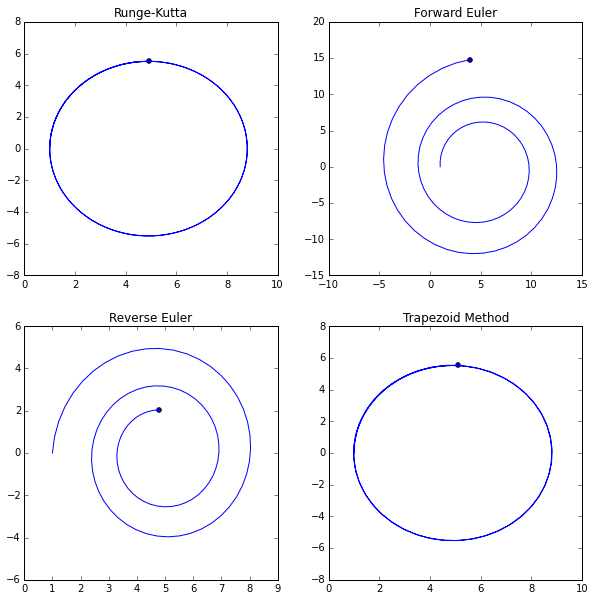

In [38]:
k = 1
m = 0.5
g = 9.8

spring_system = lambda t, y: np.array([y[1],
                                      -(k / m) * y[0] + g])
initial_condition = np.array([1, 0])
rk_points = mrk4(spring_system, 0, initial_condition, 0.1, 100)
forward_points = forward_euler(spring_system, 0, initial_condition, 0.1, 100)
reverse_points = reverse_euler(spring_system, 0, initial_condition, 0.1, 100)
trapezoid_points = trapezoid_method(spring_system, 0, initial_condition, 0.1, 100)

fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
axarr[0, 0].plot(rk_points[:, 0], rk_points[:, 1], label='Runge-Kutta')
axarr[0, 1].plot(forward_points[:, 0], forward_points[:, 1], label='Forward Euler')
axarr[1, 0].plot(reverse_points[:, 0], reverse_points[:, 1], label='Reverse Euler')
axarr[1, 1].plot(trapezoid_points[:, 0], trapezoid_points[:, 1], label='Trapezoid Method')
axarr[0, 0].scatter(rk_points[-1, 0], rk_points[-1, 1])
axarr[0, 1].scatter(forward_points[-1, 0], forward_points[-1, 1])
axarr[1, 0].scatter(reverse_points[-1, 0], reverse_points[-1, 1])
axarr[1, 1].scatter(trapezoid_points[-1, 0], trapezoid_points[-1, 1])
axarr[0, 0].set_title('Runge-Kutta')
axarr[0, 1].set_title('Forward Euler')
axarr[1, 0].set_title('Reverse Euler')
axarr[1, 1].set_title('Trapezoid Method')
plt.show()